In [1]:
import pandas as pd
import numpy as np
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances



In [2]:
%%time

'''
importing the data of genre and plot and most frequent words in the plot column
making a dict for each genre of most common words
then splitting the data into Train and test 
and making a function that trims the plot column using the most common word on the training data
'''

df=pd.read_csv('wiki_movie_plots_deduped_cleaned_genre_and_plot.csv')
data=pd.read_csv("most_frequent_words_30.csv")
dict_words={i:(data[data['Genre']==i]['Words']).to_list() for i in data['Genre'].unique()}
def reduce_words(x):
    return ' '.join([i for i in x['Plot_cleanned'].split() if i in  dict_words[x['Genre_updated']]])
    
Train=df[~pd.isnull(df['Genre_updated'])]
Test=df[pd.isnull(df['Genre_updated'])]
Train['Plot_trimmed']=Train[['Genre_updated','Plot_cleanned']].apply(lambda x: reduce_words(x),axis=1)
Train.drop_duplicates(subset='Plot_trimmed',inplace=True) #removing the duplicate columns


Wall time: 2min 8s


<timed exec>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [3]:
%%time

X_train=Train['Plot_trimmed']
y_train=Train['Genre_updated']


X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=123,stratify=y_train)


X_test=Test['Plot_cleanned']
y_test=Test['Genre_updated']

Wall time: 43.8 ms


### Model Building using tf-idf and rf

In [4]:
%%time
#converting the text data using tf-idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,2))


Wall time: 0 ns


In [5]:
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)
X_train_vectors_tfidf.shape,X_val_vectors_tfidf.shape,X_test_vectors_tfidf.shape,

((22633, 8540), (9701, 8540), (6843, 8540))

In [6]:
#pipeline for convertingthe 

text_clf = Pipeline([('tfidf', TfidfVectorizer(use_idf=True)),
                     ('clf', RandomForestClassifier(n_estimators = 100,random_state=123,n_jobs=-1))])
text_clf.fit(X_train,y_train)
#Predict y value for test dataset 
y_pred=text_clf.predict(X_val)
print(classification_report(y_val,y_pred))
print('Confusion Matrix:',confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

      action       0.84      0.90      0.87       671
   adventure       0.82      0.80      0.81       230
    animated       0.93      0.88      0.90       251
       anime       0.96      0.54      0.69        41
   biography       0.91      0.85      0.88       129
      comedy       0.80      0.82      0.81      1963
       crime       0.83      0.79      0.81       422
 documentary       0.88      0.41      0.56        37
       drama       0.79      0.92      0.85      2555
      family       0.92      0.75      0.83       178
     fantasy       0.94      0.72      0.82       152
  historical       0.93      0.62      0.74        81
      horror       0.93      0.89      0.91       440
martial_arts       1.00      0.74      0.85        38
     musical       0.92      0.75      0.83       255
     mystery       0.86      0.62      0.72       129
        noir       0.93      0.54      0.68        98
     romance       0.95    

In [7]:
data=Train[['Genre_updated','Plot_trimmed']]
data

,Genre_updated,Plot_trimmed
6,western,two two kill kill one try horse back tell men ...
7,comedy,film family life go get
10,short,get try get fall head back get fall
11,action,two later
12,western,two horse
...,...,...
42525,drama,film two take family go find tell wife family ...
42526,drama,family mother find new
42532,comedy,father also friend try family find
42533,comedy,film however two go man go man new life get life


In [8]:
data['Genre_updated'].value_counts()

drama           8515
comedy          6543
action          2235
romance         1841
thriller        1724
horror          1466
crime           1406
sci_fi           890
western          887
musical          850
animated         838
adventure        767
family           593
war              593
fantasy          507
biography        431
mystery          429
noir             325
historical       269
short            211
social           203
anime            138
spy              133
martial_arts     128
documentary      124
sports           122
teen              85
serial            81
Name: Genre_updated, dtype: int64

In [9]:
dax=df['Genre_updated'].value_counts().rename_axis('Genres_updated').reset_index(name='counts')
choices = [i for i in dax['Genres_updated'].to_list() if len(i.split())<2][0:18]

In [10]:
choices_final=[row['Genres_updated'] for i,row in dax.iterrows() if row['Genres_updated'] in choices if row['counts']>1000]

In [11]:
choices_final

['drama', 'comedy', 'action', 'romance', 'thriller', 'crime', 'horror']

In [12]:
data1=pd.DataFrame(columns = ['Genre_updated','Plot_trimmed'])
for i in choices_final:
    data1=pd.concat([data1,data[data['Genre_updated']==i]])


In [13]:
#data1

### spacy + text clustering

In [42]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [43]:
%time
data1['plot_tokenized']=data1['Plot_trimmed'].apply(nlp)

Wall time: 0 ns


In [44]:
%time
data1['plot_sent_vectors'] = data1['plot_tokenized'].apply(lambda sent: sent.vector)

Wall time: 0 ns


In [45]:
data1['plot_sent_vectors'] = data1['plot_sent_vectors'].apply(lambda x:x.tolist())
data1

,Genre_updated,Plot_trimmed,plot_tokenized,plot_sent_vectors
19,drama,day father mother take mother mother father re...,"(day, father, mother, take, mother, mother, fa...","[0.1032419204711914, 0.247483491897583, -0.221..."
20,drama,man two friend time home get house,"(man, two, friend, time, home, get, house)","[0.04797285422682762, 0.16002286970615387, -0...."
23,drama,film film go come meet life,"(film, film, go, come, meet, life)","[0.16780917346477509, 0.010754327289760113, 0...."
25,drama,time man,"(time, man)","[-0.0003350004553794861, 0.24082499742507935, ..."
26,drama,wife father time home one family later two tak...,"(wife, father, time, home, one, family, later,...","[0.13027994334697723, 0.12841781973838806, -0...."
...,...,...,...,...
41983,horror,try father family father,"(try, father, family, father)","[0.03560420125722885, 0.22435325384140015, -0...."
42154,horror,police death see friend one police home later ...,"(police, death, see, friend, one, police, home...","[0.008886030875146389, 0.1903814971446991, -0...."
42175,horror,one later later night two see see friend famil...,"(one, later, later, night, two, see, see, frie...","[0.16172008216381073, 0.1151498556137085, -0.2..."
42486,horror,friend attack one friend,"(friend, attack, one, friend)","[-0.1163172572851181, 0.20903000235557556, -0...."


In [46]:
len(data1['plot_sent_vectors'][26])

300

In [47]:
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components =2)
Y_sklearn = sklearn_pca.fit_transform(data1['plot_sent_vectors'].tolist())
kmeans = KMeans(n_clusters=7, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

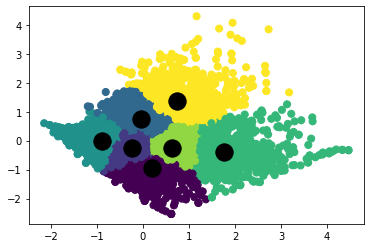

In [48]:
import matplotlib.pyplot as plt
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=1);

In [49]:
X_train=data1['plot_sent_vectors']
y_train=data1['Genre_updated']


X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.3,random_state=123,stratify=y_train)

In [50]:
%%time
# random forest
rf = RandomForestClassifier(n_estimators=100,random_state=123,n_jobs=-1)
rf.fit(pd.DataFrame(X_train.tolist()), y_train) 

Wall time: 4.24 s


RandomForestClassifier(n_jobs=-1, random_state=123)

In [51]:
y_pred=rf.predict(pd.DataFrame(X_val.tolist()))
print(classification_report(y_val,y_pred))
print('Confusion Matrix:',confusion_matrix(y_val, y_pred))

              precision    recall  f1-score   support

      action       0.87      0.78      0.82       671
      comedy       0.69      0.77      0.73      1963
       crime       0.79      0.60      0.68       422
       drama       0.73      0.83      0.78      2554
      horror       0.93      0.78      0.85       440
     romance       0.96      0.53      0.69       552
    thriller       0.77      0.60      0.67       517

    accuracy                           0.75      7119
   macro avg       0.82      0.70      0.75      7119
weighted avg       0.77      0.75      0.75      7119

Confusion Matrix: [[ 525   43   12   76    4    0   11]
 [   2 1517    0  441    0    3    0]
 [  38   36  254   22   13    0   59]
 [   1  412    1 2129    0    9    2]
 [  13   24   12   31  341    0   19]
 [   0   99    0  158    0  295    0]
 [  27   63   42   69    7    1  308]]


### text clustering using tfidf + kmeans/


In [52]:
data1

,Genre_updated,Plot_trimmed,plot_tokenized,plot_sent_vectors
19,drama,day father mother take mother mother father re...,"(day, father, mother, take, mother, mother, fa...","[0.1032419204711914, 0.247483491897583, -0.221..."
20,drama,man two friend time home get house,"(man, two, friend, time, home, get, house)","[0.04797285422682762, 0.16002286970615387, -0...."
23,drama,film film go come meet life,"(film, film, go, come, meet, life)","[0.16780917346477509, 0.010754327289760113, 0...."
25,drama,time man,"(time, man)","[-0.0003350004553794861, 0.24082499742507935, ..."
26,drama,wife father time home one family later two tak...,"(wife, father, time, home, one, family, later,...","[0.13027994334697723, 0.12841781973838806, -0...."
...,...,...,...,...
41983,horror,try father family father,"(try, father, family, father)","[0.03560420125722885, 0.22435325384140015, -0...."
42154,horror,police death see friend one police home later ...,"(police, death, see, friend, one, police, home...","[0.008886030875146389, 0.1903814971446991, -0...."
42175,horror,one later later night two see see friend famil...,"(one, later, later, night, two, see, see, frie...","[0.16172008216381073, 0.1151498556137085, -0.2..."
42486,horror,friend attack one friend,"(friend, attack, one, friend)","[-0.1163172572851181, 0.20903000235557556, -0...."


In [53]:
%%time
tfidf_vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,2))

X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(data1['Plot_trimmed']) 


Wall time: 683 ms


In [54]:
X_train_vectors_tfidf.shape,X_val_vectors_tfidf.shape,X_test_vectors_tfidf.shape,

((23730, 2530), (9701, 8540), (6843, 8540))

In [55]:
tf_idf_norm=normalize(X_train_vectors_tfidf)

In [56]:
tf_idf_array = tf_idf_norm.toarray()


In [57]:
from sklearn.cluster import KMeans
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=7, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

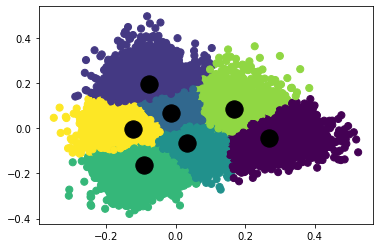

In [58]:
import matplotlib.pyplot as plt
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=1);